# Data preprocessing

Here below is where data is being imported , a weather dataset from a CSV file (weatherdata--1111422(in).csv) using pd.read_csv() and printing the entire DataFrame using df.to_string(). This allows you to inspect all rows and columns of the dataset, which includes weather attributes such as date, location (longitude, latitude), elevation, temperatures, precipitation, wind, relative humidity, and solar radiation (which currently has missing values).

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/dani-myburgh/Downloads/weatherdata_raw.csv")
print(df.head(5))

       Date   Longitude  Latitude  Elevation  Max Temperature  \
0  1/1/1979  142.188004  -11.0841          1           28.419   
1  1/2/1979  142.188004  -11.0841          1           27.973   
2  1/3/1979  142.188004  -11.0841          1           27.772   
3  1/4/1979  142.188004  -11.0841          1           26.534   
4  1/5/1979  142.188004  -11.0841          1           28.343   

   Min Temperature  Precipitation      Wind  Relative Humidity      Solar  
0           25.154      13.125229  6.931828           0.824205  21.583914  
1           24.853      23.355385  6.080869           0.869702  19.647057  
2           25.469      39.467525  6.015159           0.874135  23.399940  
3           24.851      23.830031  6.421549           0.886061  13.279332  
4           24.974       9.088613  6.161690           0.844410  24.058013  


Checking for null values

Checking for null values – Ensures the dataset has no missing data that could cause errors or bias in analysis.

 Checking for null (missing) values in each column.
 df.isnull() creates a DataFrame of True/False for missing values.
.sum() counts the number of True values (nulls) for each column

Printing the number of null values per column

In [2]:
nulls_per_column = df.isnull().sum()
print("Nulls per column:\n", nulls_per_column)

Nulls per column:
 Date                 0
Longitude            0
Latitude             0
Elevation            0
Max Temperature      0
Min Temperature      0
Precipitation        0
Wind                 0
Relative Humidity    0
Solar                0
dtype: int64


Checking for duplicates 

Checking for duplicates – Ensures all records are unique to prevent skewing results in analysis or training a model.

In [3]:
duplicate_count = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 0


Dropping the Month_Name Column, as it is not useful for the actual model.

In [4]:
df = df.drop(columns=['Longitude', 'Latitude', 'Elevation'])

Displaying Dataframe structure and column information

 Displaying DataFrame structure and column information
 df.info() shows:
 - Number of entries (rows)
 - Column names, non-null counts, and data types
 - Memory usage
 This helps check if any columns have incorrect data types or missing values.

df.info() – Checks column data types and ensures data is as expected before processing.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12868 entries, 0 to 12867
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               12868 non-null  object 
 1   Max Temperature    12868 non-null  float64
 2   Min Temperature    12868 non-null  float64
 3   Precipitation      12868 non-null  float64
 4   Wind               12868 non-null  float64
 5   Relative Humidity  12868 non-null  float64
 6   Solar              12868 non-null  float64
dtypes: float64(6), object(1)
memory usage: 703.8+ KB


Converting 'Date' column to datatime format

Currently, 'Date' is stored as an object (string). 
 Converting it to datetime64 allows for easier time-based operations 
 such as filtering by date, resampling, and plotting time series.

pd.to_datetime() – Standardizes date format for time-series operations and avoids errors in date calculations.

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

Verifying the column type change 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12868 entries, 0 to 12867
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               12868 non-null  datetime64[ns]
 1   Max Temperature    12868 non-null  float64       
 2   Min Temperature    12868 non-null  float64       
 3   Precipitation      12868 non-null  float64       
 4   Wind               12868 non-null  float64       
 5   Relative Humidity  12868 non-null  float64       
 6   Solar              12868 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 703.8 KB


Outlier Handling + Scaling

Outlier Handling with IQR Clipping

The IQRClipper transformer calculates the interquartile range (IQR) for each feature and sets lower/upper bounds at 1.5 × IQR below Q1 and above Q3.

Any values outside this range are clipped (not removed) to the boundary.

This ensures extreme outliers do not distort the scale of features, while still retaining all observations.

After clipping, features are scaled using StandardScaler (z-score normalisation).

This standardises each feature to have mean 0 and variance 1, which helps many models learn more effectively by removing bias from features measured on different scales.

Optionally, MinMaxScaler can be used instead if normalisation to a 0–1 range is more appropriate.



In [8]:

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# --- Outlier handler (IQR clipper, keeps data but caps extremes) ---
class IQRClipper(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.bounds_ = {}

    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.cols) if not isinstance(X, pd.DataFrame) else X
        for col in self.cols:
            q1, q3 = df[col].quantile([0.25, 0.75])
            iqr = q3 - q1
            self.bounds_[col] = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)
        return self

    def transform(self, X):
        df = pd.DataFrame(X, columns=self.cols) if not isinstance(X, pd.DataFrame) else X.copy()
        for col, (low, high) in self.bounds_.items():
            df[col] = df[col].clip(lower=low, upper=high)
        return df

#  pipeline
def make_preprocessor(feature_names):
    return Pipeline([
        ("outlier_clip", IQRClipper(cols=feature_names)),   
        ("scaler", StandardScaler()),                      
        
    ])


checking column names 

In [9]:
print(df.columns)

Index(['Date', 'Max Temperature', 'Min Temperature', 'Precipitation', 'Wind',
       'Relative Humidity', 'Solar'],
      dtype='object')


setting 

In [10]:
features = [ 'Max Temperature', 'Min Temperature', 'Precipitation', 'Wind',
       'Relative Humidity', 'Solar']


Running the preprocessing

In [11]:
preprocessor = make_preprocessor(features)

print("Before preprocessing:")
print(df[features].describe())

X_processed = preprocessor.fit_transform(df[features])

print("\nAfter preprocessing:")
print(pd.DataFrame(X_processed, columns=features).describe())


Before preprocessing:
       Max Temperature  Min Temperature  Precipitation          Wind  \
count     12868.000000     12868.000000   12868.000000  12868.000000   
mean         30.934948        24.548243       4.676032      4.248922   
std           2.895850         1.697789      10.363322      1.757654   
min          22.082000        15.399000       0.000000      0.597279   
25%          29.029750        23.539000       0.000000      2.846726   
50%          30.557000        24.773000       0.283241      4.275225   
75%          32.660000        25.650000       5.005648      5.436427   
max          44.570000        29.645000     225.427471     17.280624   

       Relative Humidity         Solar  
count       12868.000000  12868.000000  
mean            0.710179     21.488148  
std             0.087246      6.455625  
min             0.404470      0.000000  
25%             0.642795     18.668958  
50%             0.706245     23.039018  
75%             0.776316     26.708304  
m

Visualising 

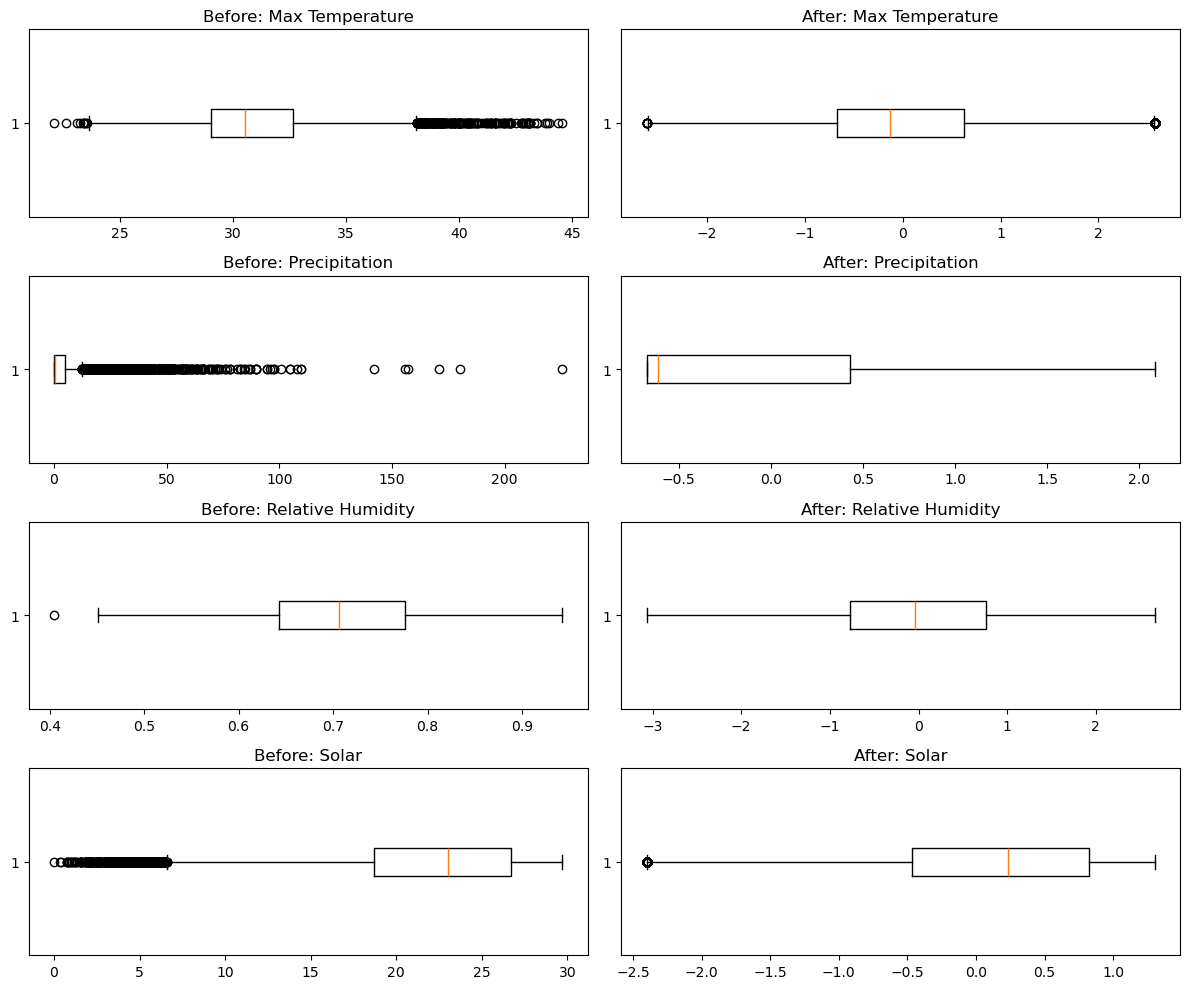

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Picked some columns to visualise
features_to_plot = ["Max Temperature", "Precipitation", "Relative Humidity", "Solar"]

fig, axes = plt.subplots(len(features_to_plot), 2, figsize=(12, 10))

for i, feat in enumerate(features_to_plot):
    # Boxplot before preprocessing
    axes[i,0].boxplot(df[feat].dropna(), vert=False)
    axes[i,0].set_title(f"Before: {feat}")
    
    # Boxplot after preprocessing
    axes[i,1].boxplot(X_processed[:, features.index(feat)], vert=False)
    axes[i,1].set_title(f"After: {feat}")

plt.tight_layout()
plt.show()


# Feature Engineering

Additional date and month features added to improve predictions. The Sin and Cos functions add continuity to the dates and months, allowing the model to view the start and end points as being close together.

In [13]:
df['Month'] = df['Date'].dt.month
df['Day Of Year'] = df['Date'].dt.dayofyear

df['Month Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month Cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['Day Of Year Sin'] = np.sin(2 * np.pi * df['Day Of Year'] / 365)
df['Day Of Year Cos'] = np.cos(2 * np.pi * df['Day Of Year'] / 365)

Defining Target Columns

In [14]:
target_columns = ['Max Temperature', 'Min Temperature']

Creating "lagged" features to improve predictions. One of the biggest determining factors for temperature on a given day is the previous day's temperature. This adds a feature to each row with the target temperature from the previous day, as well as the average target temperature from the previous week. Newly created null values are also dropped

In [15]:
for target in target_columns:
    df[f'Previous Day {target}'] = df[target].shift(1)

for target in target_columns:
    df[f'{target} Previous Weekly Average'] = df[target].shift(1).rolling(window=7).mean()

df_clean = df.dropna().reset_index(drop=True)

Printing DataFrame – Provides a final visual confirmation before saving.

In [16]:
# Printing the full DataFrame to verify that the columns are in the correct order
print(df_clean.head(5))

        Date  Max Temperature  Min Temperature  Precipitation       Wind  \
0 1979-01-08           26.715           24.951      44.527244   5.156549   
1 1979-01-09           26.753           24.877      45.905695   6.585205   
2 1979-01-10           27.562           25.444      41.409889  10.995299   
3 1979-01-11           28.523           24.627      39.130240   7.452499   
4 1979-01-12           27.977           25.110      13.187879   6.804208   

   Relative Humidity      Solar  Month  Day Of Year  Month Sin  Month Cos  \
0           0.909364   7.589135      1            8        0.5   0.866025   
1           0.894980  11.767729      1            9        0.5   0.866025   
2           0.854674  13.382385      1           10        0.5   0.866025   
3           0.850345  23.629216      1           11        0.5   0.866025   
4           0.848300  23.707742      1           12        0.5   0.866025   

   Day Of Year Sin  Day Of Year Cos  Previous Day Max Temperature  \
0         0

Saving to CSV – Stores the cleaned, well-formatted dataset for later analysis, sharing, or modeling.

In [17]:
# Exporting the cleaned and formatted DataFrame to a CSV file
# index=False ensures that the DataFrame's index is not written as a separate column in the CSV.
# This makes the file cleaner and easier to use in other tools.

df_clean.to_csv('weatherdata_cleaned.csv', index=False)

# Model Development

Define feature columns

In [18]:
feature_columns = [
    'Precipitation', 'Wind', 'Relative Humidity', 'Solar',
    'Month Sin', 'Month Cos', 'Day Of Year Cos', 'Day Of Year Cos','Previous Day Max Temperature',
    'Previous Day Min Temperature', 'Max Temperature Previous Weekly Average', 'Min Temperature Previous Weekly Average'
]

Split data into testing and training sets

In [19]:
split_idx = int(len(df_clean) * 0.8)
train_data = df_clean.iloc[:split_idx]
test_data = df_clean.iloc[split_idx:]

X_train = train_data[feature_columns]
y_train = train_data[target_columns]

X_test = test_data[feature_columns]
y_test = test_data[target_columns]

Use Gridsearch to find optimal hyperparameters for the model

In [20]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

base_model = MultiOutputRegressor(RandomForestRegressor(random_state=42, n_jobs=-1))

In [21]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [10, 15, 20],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='r2',
    n_jobs=1,
    verbose=1
)

grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_

print("\nBest hyperparameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param.replace('estimator__', '')}: {value}")
print(f"Best cross-validation R² score: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best hyperparameters found:
  max_depth: 20
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 300
Best cross-validation R² score: 0.8417


Fitting the model to make predictions

In [22]:
y_test_pred = model.predict(X_test)

Model Evaluation

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

print("\nOptimized Model Performance:")
for i, target in enumerate(target_columns):
    test_rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_test_pred[:, i]))
    test_r2 = r2_score(y_test.iloc[:, i], y_test_pred[:, i])
    print(f"{target}: RMSE = {test_rmse:.2f}°C, R² = {test_r2:.3f}")


Optimized Model Performance:
Max Temperature: RMSE = 1.68°C, R² = 0.577
Min Temperature: RMSE = 0.67°C, R² = 0.829


Visualize Results

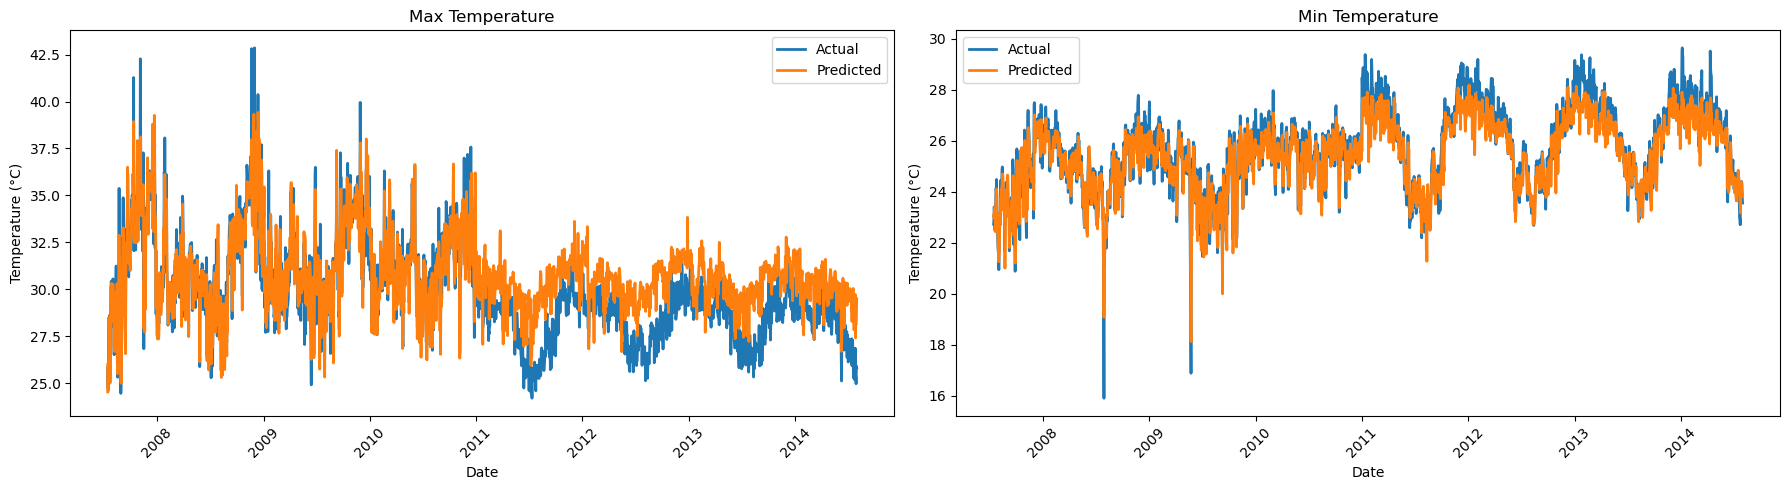

In [24]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

for i, target in enumerate(target_columns):
    test_dates = test_data['Date'].values
    axes[i].plot(test_dates, y_test.iloc[:, i].values, label='Actual', linewidth=2)
    axes[i].plot(test_dates, y_test_pred[:, i], label='Predicted', linewidth=2)
    axes[i].set_title(target)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Temperature (°C)')
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()